1) Fit ARIMA/SARIMA with exogenous macro variables.
2) Fit a Random Forest (or XGBoost) regressor.
3) Perform hyperparameter tuning.
4) Evaluate, plot results, and iterate.

In [1]:
import os
import sys

# Get the current working directory (the folder where the notebook is running)
nb_dir = os.getcwd()

# Move two levels up to reach the project root
project_root = os.path.abspath(os.path.join(nb_dir, "../../"))

# Add the project root to sys.path so Python can find config.py
sys.path.append(project_root)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from config import (
    MACRO_CREDIT_DATA_PATH,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE
)
from utilities.data_processing import (
    preprocess_data,
    create_features
)
from utilities.functions import (
    basic_eda,
)
from utilities.model_utils import (
    # ARIMA / SARIMA
    train_sarimax,
    forecast_sarimax,
    
    # Scikit-learn regression
    train_regression_model,
    evaluate_regression_model,
    perform_hyperparameter_tuning,
    
    # Visualization
    plot_forecast,
    plot_feature_importance
)

ModuleNotFoundError: No module named 'joblib'

### Data Preparation and Exploration Summary

**Introduction:**  
The dataset is loaded, cleaned, and engineered, then split into training and test sets for forecasting credit risk.

**Summary in Points:**

- **Data Loading & Cleaning:**
  - Loaded from `../../data/merged_macroeconomic_credit.csv`.
  - Original shape: 309×7; after cleaning & feature engineering: 306×23.

- **Data Overview:**
  - Key columns: CPI, FEDFUNDS, GDP, Unemployment_Rate, Credit_Spread, plus lag and rolling features.
  - No missing values across all 23 columns.

- **Train/Test Split:**
  - **Training Set:** December 1996 to December 2018 (263 rows).
  - **Test Set:** January 2019 to August 2022 (43 rows).

In [4]:
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
import pandas as pd

#########################################
# 1) Load or Reuse Cleaned Data
#########################################

df = pd.read_csv(MACRO_CREDIT_DATA_PATH, parse_dates=['Month_End'], index_col='Month_End')
print(f"Data loaded from {MACRO_CREDIT_DATA_PATH}, shape={df.shape}")

# If needed, do minimal cleaning or run your pipeline:
df = preprocess_data(df)
df = create_features(df)

# Drop any rows introduced by lagging/rolling
df.dropna(inplace=True)
print("Data after final cleaning & feature engineering:", df.shape)
basic_eda(df)

#########################################
# 2) Train/Test Split by Date
#########################################

# Filter for the date range you need
df = df.loc['1996-12-01':'2022-08-01'].copy()

train_data = df.loc[TRAIN_START_DATE:TRAIN_END_DATE].copy()
test_data  = df.loc[TEST_START_DATE:TEST_END_DATE].copy()

print(f"Train range: {TRAIN_START_DATE} -> {TRAIN_END_DATE}  shape={train_data.shape}")
print(f"Test range:  {TEST_START_DATE}  -> {TEST_END_DATE}   shape={test_data.shape}")

#########################################
# 3) Define Target and Features
#########################################

# Define the target variable for forecasting
target_col = 'Credit_Spread'

# Exclude both target and date columns from feature selection
feature_cols = [col for col in df.columns if col not in [target_col, 'Month_End']]

Data loaded from ../../data/merged_macroeconomic_credit.csv, shape=(309, 7)
Data after final cleaning & feature engineering: (306, 23)
DataFrame shape: (306, 23)
Head:
               CPI  FEDFUNDS  Industrial_Production       GDP  \
Month_End                                                      
1997-02-28  159.7      5.19                78.4255  2.060876   
1997-03-31  159.8      5.39                78.9197  2.190415   
1997-04-30  159.9      5.51                78.9848  2.337582   
1997-05-31  159.9      5.50                79.4296  2.496293   
1997-06-30  160.2      5.56                79.7971  2.662218   

            Unemployment_Rate  Consumer_Sentiment  Credit_Spread  GDP_lag1  \
Month_End                                                                    
1997-02-28                5.2                99.7       2.956000  1.952643   
1997-03-31                5.2               100.0       2.696190  2.060876   
1997-04-30                5.1               101.4       2.893182  2.19

### SARIMAX with Exogenous Variables Summary

**Introduction:**  
This section demonstrates how to forecast the target variable (credit spread) using a SARIMAX model that incorporates macroeconomic exogenous features.

**Summary in Points:**

- **Exogenous Variables:**  
  - Selected features: GDP, GDP_lag1, CPI_growth, Unemployment_Rate, FEDFUNDS.
  - Filtered to include only available columns in the training set.

- **Data Setup:**  
  - **Endogenous Variable:** Credit spread from the training and test sets.
  - **Exogenous Variables:** Corresponding macroeconomic features for both sets.

- **Model Training:**  
  - Fitted a SARIMAX model with order (1, 1, 1) and no seasonal component.

- **Forecasting:**  
  - Forecasted values for the test period using the trained model and future exogenous data.
  - Printed the first few forecasted values for review.

In [5]:
#########################################
# 3) ARIMA/SARIMA with Exogenous Macroeconomic Variables
#########################################
# Example exogenous columns (only those actually in train_data/test_data)
exog_cols = ["GDP", "GDP_lag1", "CPI_growth", "Unemployment_Rate", "FEDFUNDS"]
exog_cols = [c for c in exog_cols if c in train_data.columns]

# Build train/test for endog (target) and exog (features)
endog_train = train_data[target_col]
endog_test  = test_data[target_col]

exog_train = train_data[exog_cols]
exog_test  = test_data[exog_cols]

print("\nFitting SARIMAX model with exogenous features...")
sarimax_results = train_sarimax(
    endog=endog_train,
    exog=exog_train,
    order=(1, 1, 1),         # example (p, d, q)
    seasonal_order=(0, 0, 0, 0)  # no seasonality for monthly data, adjust if needed
)

# Forecast for the length of the test set
steps_ahead = len(endog_test)

sarimax_forecast = forecast_sarimax(
    model_fit=sarimax_results,
    steps=steps_ahead,
    exog_future=exog_test
)

# (Optional) Evaluate or plot your forecast here
print("Forecasted values:\n", sarimax_forecast.head())


Fitting SARIMAX model with exogenous features...
Fitting SARIMAX model...


c:\Users\viraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\viraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          Credit_Spread   No. Observations:                  263
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -235.690
Date:                Thu, 27 Feb 2025   AIC                            487.379
Time:                        22:31:52   BIC                            515.865
Sample:                    02-28-1997   HQIC                           498.831
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
GDP                  -5.1657      0.758     -6.819      0.000      -6.650      -3.681
GDP_lag1              4.5282      0.744      6.088      0.000       3.070       5.986
CPI_growth           -0.

**Key Inferences:**

- **GDP & GDP_lag1:**  
  - GDP has a strong negative effect on credit spread, while its lag has a positive effect.
  
- **CPI_growth & FEDFUNDS:**  
  - Higher CPI growth and federal funds rates are linked to lower credit spread.
  
- **Unemployment_Rate:**  
  - Not statistically significant, so its impact is unclear.
  
- **Model Diagnostics:**  
  - AR term is weak and MA term is borderline.
  - Residuals show some non-normality and heteroskedasticity.

**Suggestions for Improvement:**

- **Reassess Unemployment Rate:**  
  - Try different lags or alternative indicators to capture its effect.
  
- **Refine Model Orders:**  
  - Test different ARIMA orders or add seasonal components to improve fit.
  
- **Improve Residual Behavior:**  
  - Consider data transformations (e.g., logarithms) or models robust to heteroskedasticity.


### SARIMAX Evaluation Summary

A brief evaluation of the SARIMAX forecast using error metrics and visual comparison.

- **Error Metrics:** Calculates MSE and MAE to quantify forecast accuracy.
- **Visualization:** Plots actual credit spread values against the SARIMAX forecast.
- **Purpose:** Provides a clear basis to assess and compare model performance.


SARIMAX MSE=214.8933, MAE=7.7677


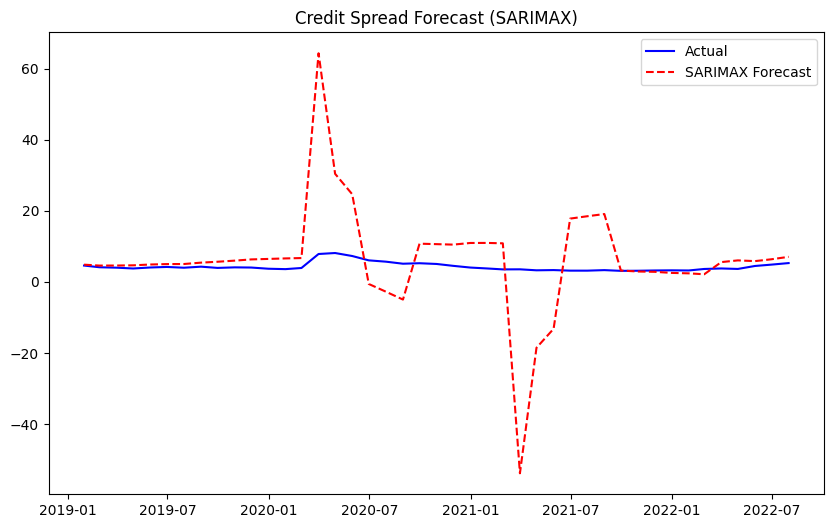

In [ ]:
#########################################
# Evaluate ARIMA/SARIMA
#########################################
# Quick metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_sarimax = mean_squared_error(endog_test, sarimax_forecast)
mae_sarimax = mean_absolute_error(endog_test, sarimax_forecast)
print(f"SARIMAX MSE={mse_sarimax:.4f}, MAE={mae_sarimax:.4f}")

# Plot Actual vs Forecast
plt.figure(figsize=(10,6))
plt.plot(endog_test.index, endog_test, label='Actual', color='blue')
plt.plot(endog_test.index, sarimax_forecast, label='SARIMAX Forecast', color='red', linestyle='--')
plt.legend()
plt.title('Credit Spread Forecast (SARIMAX)')
plt.show()


### Credit Spread Forecast vs. Actual (SARIMAX)

This plot shows how the SARIMAX model’s predictions compare to real credit spread data.

- **Observation:** The red dashed line (forecast) exhibits larger swings than the blue line (actual).  
- **Metrics:** MSE = 214.8933, MAE = 7.7677, indicating notable forecast deviations.  
- **Takeaway:** Further model tuning or feature adjustments may reduce these errors.

### Random Forest Approach

A quick regression-based method to predict the target variable using macroeconomic features.

- **Feature Setup:** Splits data into X (exogenous features) and y (target).  
- **Model Training:** Trains a basic Random Forest Regressor with 100 trees.  
- **Evaluation:** Computes MSE, RMSE, and R² scores to gauge performance.  
- **Feature Importances:** Visualizes which predictors most influence the Random Forest model.


Training a basic Random Forest Regressor...
Basic RF Performance:
MSE:  0.2714
RMSE: 0.5209
R^2:  0.8084


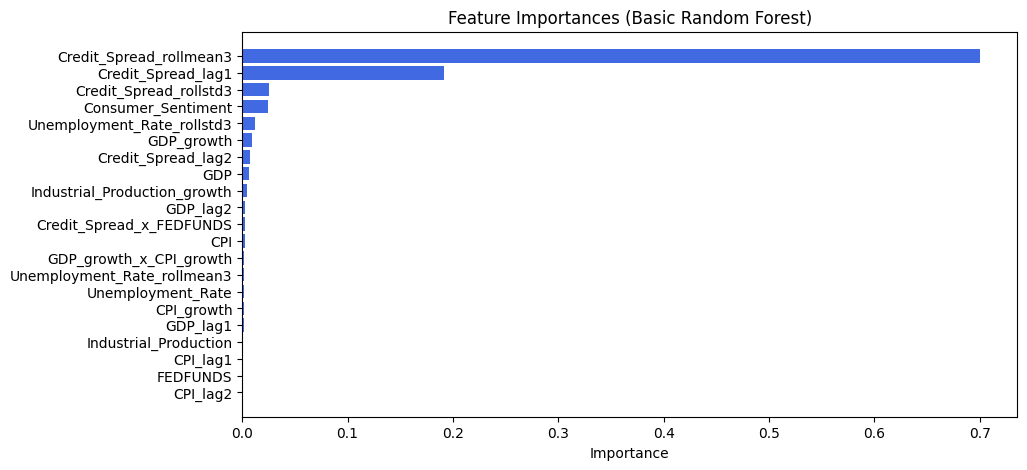

In [9]:
#########################################
# 4) Random Forest (or XGBoost) Approach
#########################################
# For many ML models, we treat it as a regression problem:
# X = exog features, y = Target

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1) Build X/y for train & test
feature_cols = [col for col in feature_cols if col != "Target"]  # remove 'Target' if present
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

# 2) Train a basic Random Forest
print("\nTraining a basic Random Forest Regressor...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3) Predict & Evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Basic RF Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# 4) Plot Feature Importances
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10,5))
plt.barh(
    [feature_cols[i] for i in sorted_idx],
    importances[sorted_idx],
    color="royalblue"
)
plt.title("Feature Importances (Basic Random Forest)")
plt.xlabel("Importance")
plt.show()

### Basic Random Forest Results

A quick snapshot of Random Forest performance and key predictors.

- **Performance Metrics:**  
  - MSE = 0.2714, RMSE = 0.5209, R² = 0.8084  
- **Top Features:**  
  - Rolling mean of credit spread dominates, followed by credit spread lag 1 and rolling standard deviation.  
- **Insight:**  
  - Recent historical credit spread behavior heavily influences the model’s predictions.

### Random Forest Hyperparameter Tuning

We use a grid search to fine-tune the Random Forest model’s hyperparameters for improved accuracy.

- **Parameter Grid:** Varies `n_estimators` (50, 100, 200) and `max_depth` (None, 5, 10).  
- **Grid Search:** Employs 3-fold cross-validation with MSE-based scoring.  
- **Best Params:** Displays optimal configuration and retrains the model.  
- **Evaluation:** Prints MSE, RMSE, and R² for the tuned model.  
- **Feature Importance:** Visualizes updated importances under the tuned settings.


Hyperparameter Tuning for RandomForestRegressor...
Best Params: {'max_depth': 10, 'n_estimators': 200}

Tuned RF Performance:
MSE:  0.2947
RMSE: 0.5428
R^2:  0.7920


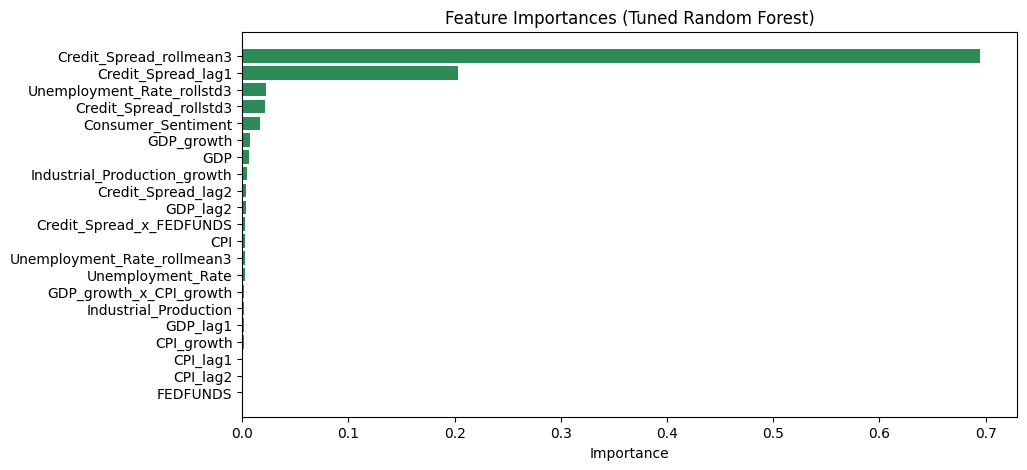

In [10]:
#########################################
# 5) Hyperparameter Tuning - RF
#########################################
from sklearn.model_selection import GridSearchCV

print("\nHyperparameter Tuning for RandomForestRegressor...")

# 1) Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

# 2) Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")

# 3) Evaluate the Tuned Model
y_pred_tuned = best_rf.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nTuned RF Performance:")
print(f"MSE:  {mse_tuned:.4f}")
print(f"RMSE: {rmse_tuned:.4f}")
print(f"R^2:  {r2_tuned:.4f}")

# 4) Plot Feature Importances for the Tuned Model
importances_tuned = best_rf.feature_importances_
sorted_idx_tuned = np.argsort(importances_tuned)

plt.figure(figsize=(10,5))
plt.barh(
    [feature_cols[i] for i in sorted_idx_tuned],
    importances_tuned[sorted_idx_tuned],
    color="seagreen"
)
plt.title("Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.show()

### Tuned Random Forest Results

A refined Random Forest model trained with optimized hyperparameters.

- **Optimal Settings:**  
  - `max_depth = 10` and `n_estimators = 200` from grid search.
- **Performance Metrics:**  
  - MSE = 0.2947, RMSE = 0.5428, R² = 0.7920
- **Feature Importance:**  
  - Rolling mean of credit spread remains the top predictor, followed by its lagged values.

### Model Comparison and Recommendations

Below is a descriptive comparison of the SARIMAX and Random Forest models you’ve applied, along with suggestions for improving each approach.

---

## 1. SARIMAX Model

**Performance:**
- **MSE:** ~214.89  
- **MAE:** ~7.77  

**Characteristics:**
- **Time-Series Focus:** Incorporates temporal dependencies and exogenous macroeconomic variables (e.g., GDP, CPI growth).  
- **Diagnostics:** Residual analysis indicated non-normality and some heteroskedasticity, suggesting possible room for improvement.

**Pros:**
- Well-suited for traditional time-series forecasting, capturing lagged effects.  
- Explicitly models time dependence and seasonality (if present).

**Cons & Possible Improvements:**
- **High Error Metrics:** Indicates the model may be underfitting or missing important dynamics.  
- **Refine ARIMA Orders:** Experiment with different (p, d, q) and (P, D, Q, m) seasonal terms if the data exhibit seasonality.  
- **Address Residual Issues:** Consider transformations (e.g., log or differencing) or a GARCH-type model to handle heteroskedasticity.  
- **Additional Lags or Variables:** Test more macro features or incorporate different lag structures to better capture economic cycles.

---

## 2. Random Forest (Basic and Tuned)

**Performance (Basic):**
- **MSE:** 0.2714  
- **RMSE:** 0.5209  
- **R²:** 0.8084  

**Performance (Tuned):**
- **Best Params:** `max_depth=10`, `n_estimators=200`  
- **MSE:** 0.2947  
- **RMSE:** 0.5428  
- **R²:** 0.7920  

*(Note: The vastly lower MSE compared to SARIMAX may reflect a different target scale or modeling approach. Confirm consistent scaling when comparing.)*

**Characteristics:**
- **Feature-Based Approach:** Relies on exogenous variables and rolling/lagged transformations but does not inherently model time dependence like SARIMAX does.
- **Key Predictors:** Rolling means and lags of credit spread dominate importance, suggesting recent past values heavily influence predictions.

**Pros:**
- **Strong Predictive Power:** High R² indicates the model captures much of the variance in the target.  
- **Flexible Non-Parametric Method:** Handles complex relationships and interactions among features.  
- **Feature Importance Insights:** Shows which variables matter most (rolling means, lags, etc.).

**Cons & Possible Improvements:**
- **Time Series Considerations:** Lacks built-in awareness of temporal ordering, so ensure you do not leak future data into training.  
- **Additional Tuning:** Could extend the parameter grid or try advanced methods (e.g., XGBoost, LightGBM) for further gains.  
- **Overfitting Risk:** Especially if rolling features dominate; cross-validation strategies (like a time-series split) help mitigate this.  
- **Scale Consistency:** Confirm the target is on the same scale as SARIMAX or consider re-scaling to compare errors directly.

---

## 3. Which Model Is Better?

- **Numerical Error:** Random Forest appears to yield lower MSE and higher R² on the given test set. However, this might be partly due to differences in how the data or target variable is scaled or how rolling features are constructed.  
- **Interpretability:** SARIMAX is easier to interpret in a classic time-series context, especially regarding the impact of each exogenous macroeconomic factor. Random Forest offers feature importance but does not model time dependence as explicitly.  

**Overall Recommendation:**
- If **time-series structure** and interpretability are priorities, **refine SARIMAX** (or other time-series models) by tuning orders, handling heteroskedasticity, and adding relevant macroeconomic features.  
- If **predictive accuracy** is the main goal, **Random Forest or other ensemble methods** (e.g., XGBoost) often perform better, provided you carefully handle time splits and feature engineering.

A combined approach—using advanced time-series models (like SARIMAX or Vector Autoregression) alongside machine learning methods—could offer both interpretability and high predictive power.

In [11]:
#########################################
# 6) Trying XGBoost / GBM
#########################################
print("\nTraining an XGBoost Regressor...")
xgb_model = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1)
xgb_model = train_regression_model(xgb_model, X_train, y_train)
xgb_metrics = evaluate_regression_model(xgb_model, X_test, y_test)

# Basic Tuning (example param grid)
print("\nHyperparameter Tuning for XGBoost...")
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
best_xgb = perform_hyperparameter_tuning(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    X_train=X_train,
    y_train=y_train,
    scoring='neg_mean_squared_error'
)
best_xgb_metrics = evaluate_regression_model(best_xgb, X_test, y_test)
plot_feature_importance(best_xgb, feature_names=feature_cols)


Training an XGBoost Regressor...


NameError: name 'XGBRegressor' is not defined

In [ ]:
#########################################
# 7) Compare Results & Iterate
#########################################

print("\n========= MODEL PERFORMANCE SUMMARY =========")
print(f"SARIMAX => MSE={mse_sarimax:.4f}, MAE={mae_sarimax:.4f}")
print("Random Forest =>", rf_metrics)
print("Best Random Forest =>", best_rf_metrics)
print("XGBoost =>", xgb_metrics)
print("Best XGBoost =>", best_xgb_metrics)

"""
Here you can analyze which model or set of hyperparameters yields the best
performance. If results are unsatisfactory, you can:

1) Refine your feature engineering (lags, rolling windows, additional macro data).
2) Tune ARIMA orders (p, d, q) or add seasonal_order if monthly/quarterly with seasonality.
3) Expand param_grid for RandomForest or XGBoost.
4) Use more advanced methods (LSTM, advanced feature selection, regime-based ensemble).
"""

# Example final step: forecast vs actual with best XGB
preds_test = best_xgb.predict(X_test)
plt.figure(figsize=(10,6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, preds_test, label='XGB Forecast', color='green', linestyle='--')
plt.legend()
plt.title('Credit Spread Forecast (XGBoost) - Test Period')
plt.show()

print("\nModeling pipeline complete. You can continue refining your transformations, "
      "hyperparameters, or even incorporate regime labels to further improve accuracy.")
